In [ ]:
from pathlib import Path
import os
import glob
import cv2
import matplotlib.pyplot as plt

BASE_DIR = Path("..").resolve()
COLLECT_DIR = BASE_DIR / "data" / "processed" / "all_frames_1080p"
CLEAN_DIR = BASE_DIR / "data" / "processed" / "clean_1080p"

CLEAN_DIR.mkdir(parents=True, exist_ok=True)

frames = sorted(glob.glob(str(COLLECT_DIR / "*.png")))
print("Collected frames:", len(frames))


Collected frames: 600


In [2]:
TARGET_WIDTH = 480  
saved = 0
skipped = 0

for p in frames:
    img = cv2.imread(p)
    if img is None:
        skipped += 1
        continue

    h, w, _ = img.shape
    scale = TARGET_WIDTH / w
    new_w = TARGET_WIDTH
    new_h = int(h * scale)

    resized = cv2.resize(img, (new_w, new_h))

    fname = os.path.basename(p)
    cv2.imwrite(str(CLEAN_DIR / fname), resized)
    saved += 1

print("Saved:", saved)
print("Skipped:", skipped)


Saved: 600
Skipped: 0


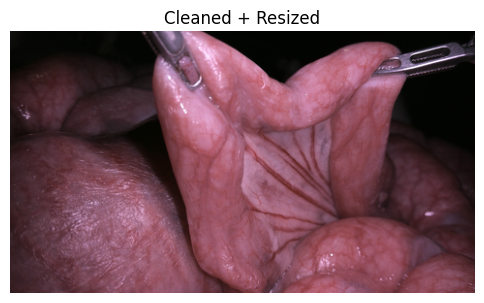

In [6]:
import random

sample = random.choice(os.listdir(CLEAN_DIR))
img = cv2.imread(str(CLEAN_DIR / sample))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.title("Cleaned + Resized")
plt.axis("off")
plt.show()


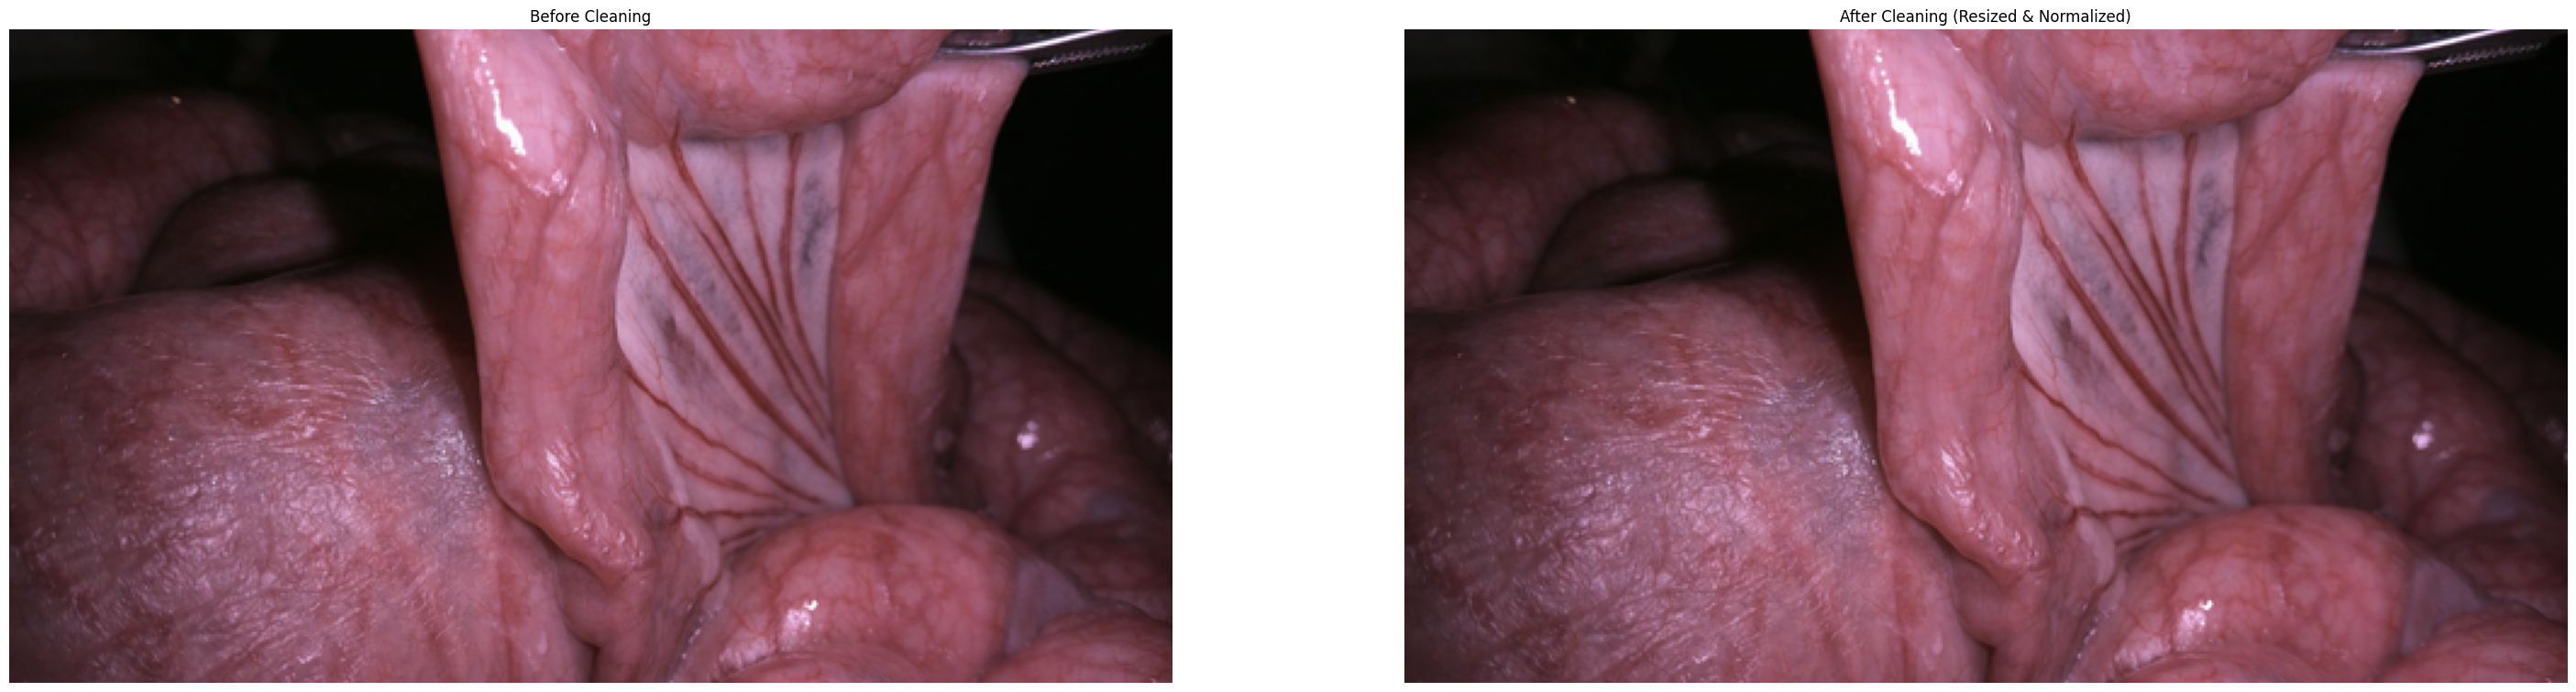

In [8]:
#BEFORE AND AFTER
import matplotlib.pyplot as plt
import cv2

raw = cv2.imread("../data/processed/all_frames_480p/frame_0000.png")
clean = cv2.imread("../data/processed/clean_480p/frame_0000.png")

raw_rgb   = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
clean_rgb = cv2.cvtColor(clean, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(36,10))
plt.subplot(1,2,1)
plt.imshow(raw_rgb)
plt.title("Before Cleaning")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(clean_rgb)
plt.title("After Cleaning (Resized & Normalized)")
plt.axis("off")

plt.show()


In [7]:
#trying a different cleaning approach

import cv2
import numpy as np

def clean_surgical_image(img):
    # 1. Bilateral filter (smooths while preserving edges - better for surgical images)
    bilateral = cv2.bilateralFilter(img, 9, 75, 75)
    
    # 2. Convert to HSV for better color handling
    hsv = cv2.cvtColor(bilateral, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # 3. Enhance value channel with adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    v_enhanced = clahe.apply(v)
    
    # 4. Slightly boost saturation for better tissue differentiation
    s_enhanced = cv2.convertScaleAbs(s, alpha=1.2, beta=10)
    
    # 5. Merge back and convert to BGR
    hsv_enhanced = cv2.merge((h, s_enhanced, v_enhanced))
    enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)
    
    # 6. Gentle unsharp mask for clarity without noise amplification
    gaussian = cv2.GaussianBlur(enhanced, (0, 0), 2.0)
    sharp = cv2.addWeighted(enhanced, 1.5, gaussian, -0.5, 0)
    
    return sharp


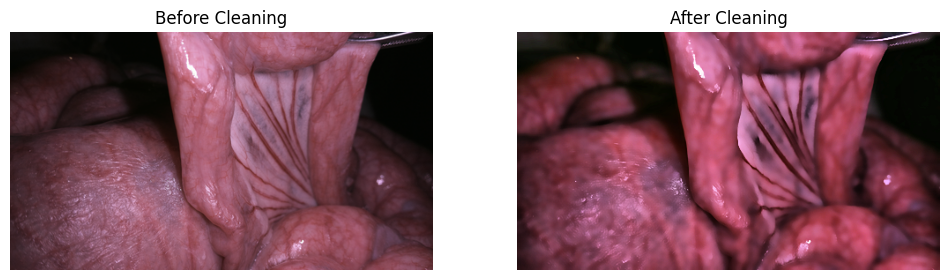

In [8]:
import matplotlib.pyplot as plt

# Use an actual frame from your collected data
raw = cv2.imread("../data/processed/all_frames_480p/frame_0000.png")
clean = clean_surgical_image(raw)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(raw, cv2.COLOR_BGR2RGB))
plt.title("Before Cleaning"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(clean, cv2.COLOR_BGR2RGB))
plt.title("After Cleaning"); plt.axis("off")

plt.show()
